In [123]:
import pandas as pd
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from scipy.special import comb
import pandas as pd
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
class basic_CA_financial_market:
    def __init__(self, n_investors, max_steps, initial_p_hold_stock, plot_results_flag):
        self.n_investors = n_investors
        self.max_steps = max_steps
        self.p_hold_stock = initial_p_hold_stock
        self.market_states = []
        self.big_trader_states = []
        self.stock_A_market_state = []
        self.stock_B_market_state = []
    
    def update_state(self, current_market_state, markovian, alpha = 0.3, prev_market_state=None, small_trader = False):
        
        if not markovian:
            # Use weighted average of current and previous state
            p_hold_stock = alpha * (current_market_state / self.n_investors) + \
                          (1 - alpha) * (prev_market_state / self.n_investors)
        else:
            # Markovian: only current state matters
            p_hold_stock = current_market_state / self.n_investors  
        
        # Clip probability to valid range [0, 1]
        p_hold_stock = np.clip(p_hold_stock, 0.0, 1.0)
        
        # Return scalar instead of array
        return np.random.binomial(self.n_investors, p_hold_stock)

    def update_state_big_small(self, current_market_state, big_traders_num, alpha, small_trader = False, big_traders_state = None):

        n_investors = self.n_investors
        
        if small_trader == True:
            n_investors = n_investors - big_traders_num
            p_hold_stock = (1-alpha)*(current_market_state / self.n_investors)+alpha*(big_traders_state/big_traders_num)

        else:
            n_investors = big_traders_num
            p_hold_stock = current_market_state / self.n_investors  
        
        # Clip probability to valid range [0, 1]
        p_hold_stock = np.clip(p_hold_stock, 0.0, 1.0)
        
        # Return scalar instead of array
        return np.random.binomial(n_investors, p_hold_stock)
    
    def update_state_A(self, current_market_state, prev_market_state, num_A, alpha, beta):
        N_A = (num_A/self.n_investors)
        N_B = (prev_market_state - num_A)/self.n_investors
        p_hold_A = alpha*N_A+beta*N_B

        p_hold_A = np.clip(p_hold_A, 0.0, 1.0)

        return np.random.binomial(current_market_state, p_hold_A)

    
    def run_basic_simulation(self, markovian=True, alpha=0.3):
        
        # Initialize market state
        self.market_states = []
        current_market_state = np.random.binomial(self.n_investors, self.p_hold_stock)
        self.market_states.append(current_market_state)
        steps = 0
        
        while (current_market_state != 0 and 
               current_market_state != self.n_investors and 
               steps < self.max_steps):
            
            if not markovian and steps >= 1:
                # For non-Markovian: use current state and state from two steps back
                prev_state = self.market_states[-2]  # State at t-1

                current_market_state = self.update_state(
                    current_market_state, 
                    markovian=False, 
                    alpha=alpha, 
                    prev_market_state=prev_state
                )
            else:
                # Markovian update
                current_market_state = self.update_state(
                    current_market_state, 
                    markovian=True, 
                    alpha=alpha
                )
            
            self.market_states.append(current_market_state)
            steps += 1

    def run_two_type_traders_model(self, percentage_big_traders = 0.2, alpha = 0.3):

        self.market_states = []
        steps = 0

        alpha = np.clip(alpha, 0.0, 1.0)
        p_big_traders = np.clip(percentage_big_traders, 0.0, 1.0)

        n_big_traders = np.round(p_big_traders*self.n_investors,0)
        n_small_traders = self.n_investors - n_big_traders

        current_market_state_big = np.random.binomial(n_big_traders, self.p_hold_stock)
        current_market_state_small = np.random.binomial(n_small_traders, self.p_hold_stock)
        
        current_market_state_total = current_market_state_big + current_market_state_small
        self.market_states.append(current_market_state_total)
        self.big_trader_states.append(current_market_state_big)

        while (current_market_state_total != 0 and 
            current_market_state_total != self.n_investors and 
            steps < self.max_steps):     


            current_market_state_big = self.update_state_big_small(
                current_market_state_total, 
                n_big_traders,
                alpha = alpha,
                small_trader= False
            )      

            current_market_state_small = self.update_state_big_small(
                current_market_state_total, 
                n_big_traders,
                alpha = alpha,
                small_trader= True,
                big_traders_state= current_market_state_big
            )           
            
            current_market_state_total = current_market_state_small+current_market_state_big
            
            self.market_states.append(current_market_state_total)
            self.big_trader_states.append(current_market_state_big)
            
            steps += 1 

    def run_two_stocks_model(self, init_prob_hold_A = 0.5, alpha = 1, beta = 0.05):
        
        self.market_states = []
        self.stock_A_market_state = []
        self.stock_B_market_state = []
        
        current_market_state_total = np.random.binomial(self.n_investors, self.p_hold_stock)
        current_stock_A_market = np.random.binomial(current_market_state_total, init_prob_hold_A)
        current_stock_B_market = current_market_state_total - current_stock_A_market

        self.market_states.append(current_market_state_total)
        self.stock_A_market_state.append(current_stock_A_market)
        self.stock_B_market_state.append(current_stock_B_market)
        
        steps = 0

        while (current_market_state_total != 0 and 
               current_stock_A_market != self.n_investors and current_stock_B_market != self.n_investors and 
               steps < self.max_steps):  
            
                current_market_state_total = self.update_state(
                    current_market_state_total, 
                    markovian=True, 
                )

                current_stock_A_market = self.update_state_A(
                    current_market_state_total,
                    self.market_states[-1],
                    current_stock_A_market,
                    alpha,
                    beta
                )

                current_stock_B_market = current_market_state_total - current_stock_A_market

                self.market_states.append(current_market_state_total)
                self.stock_A_market_state.append(current_stock_A_market)
                self.stock_B_market_state.append(current_stock_B_market)

                steps += 1
    
    def plot_results(self, two_traders = False):

        if two_traders == True:
            plt.plot(self.market_states, label = "Market States", alpha = 0.5)
            plt.plot(self.big_trader_states, label = "Market States (Big Traders)")
            small_trader_states = np.array(self.market_states)-np.array(self.big_trader_states)            
            plt.plot(small_trader_states, label = "Market States (Small Traders)")
        
        else:
            plt.plot(self.market_states, label = "Market States")
       
        plt.xlabel('Time Step')
        plt.ylabel('Number of Agents Holding Stock')
        plt.title('Market State Evolution')
        plt.grid(False)
        plt.legend()
        plt.show()

    def plot_two_stocks_results(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.market_states, label="Total Stock Holders", color='black', linestyle='--')
        plt.plot(self.stock_A_market_state, label="Stock A Holders", color='blue')
        plt.plot(self.stock_B_market_state, label="Stock B Holders", color='red')
        plt.xlabel('Time Step')
        plt.ylabel('Number of Investors')
        plt.title('Two Stocks Market State Evolution')
        plt.legend()
        plt.show()
    
    def switch_state_probability_calc(self, i, j):
        """Calculate transition probability from state i to j"""
        
        # Validate states
        if i < 0 or i > self.n_investors or j < 0 or j > self.n_investors:
            return 0.0
        
        # Handle absorbing states
        if i == 0 or i == self.n_investors:
            return 1.0 if j == i else 0.0
        
        # Calculate transition probability
        p = i / self.n_investors
        return comb(self.n_investors, j) * (p ** j) * ((1 - p) ** (self.n_investors - j))
    
    def generate_transition_matrix(self, as_pandas_df=False, plot_heatmap=False, size_pic=(12, 10)):
        matrix_size = self.n_investors + 1
        transition_matrix = np.zeros((matrix_size, matrix_size))
        
        for i in range(matrix_size):
            for j in range(matrix_size):
                transition_matrix[i, j] = self.switch_state_probability_calc(i, j)
        
        if as_pandas_df:
            states = [f'S{i}' for i in range(matrix_size)]
            df = pd.DataFrame(transition_matrix, index=states, columns=states)
            
            if plot_heatmap:
                plt.figure(figsize=size_pic)
                sns.heatmap(
                    df, 
                    annot=True, 
                    fmt=".2f", 
                    cmap="viridis",
                    cbar_kws={'label': 'Transition Probability'}
                )
                plt.title('Markov Transition Matrix')
                plt.show()
            return df
        
        return transition_matrix
    
    def absorption_time(self, print_flag=True):
        """Calculate theoretical absorption time using paper's formula"""
        S = self.p_hold_stock  # Initial market share proportion
        
        if S <= 0 or S >= 1:
            if print_flag:
                print("Initial market share must be between 0 and 1 (exclusive)")
            return 0.0

        abs_time = -2 * (S * np.log(S) + (1 - S) * np.log(1 - S))
        
        if print_flag:
            print(f"Theoretical absorption time: {abs_time:.4f} (continuous time units)")
            print(f"Estimated discrete steps: {abs_time * self.n_investors:.1f}")
        
        return abs_time

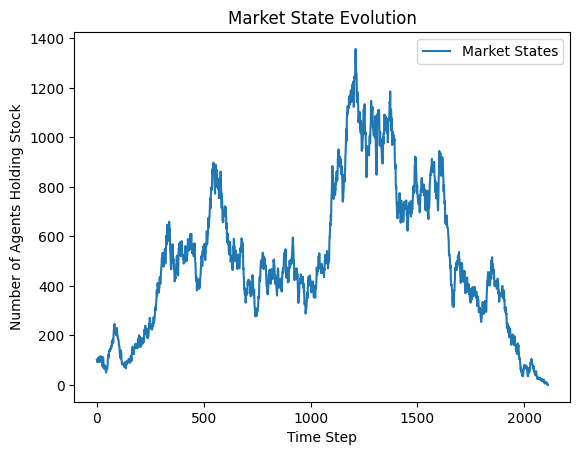

In [125]:
CA_basic = basic_CA_financial_market(10000, 10000, 0.01, True)
CA_basic.run_basic_simulation(True)
CA_basic.plot_results()

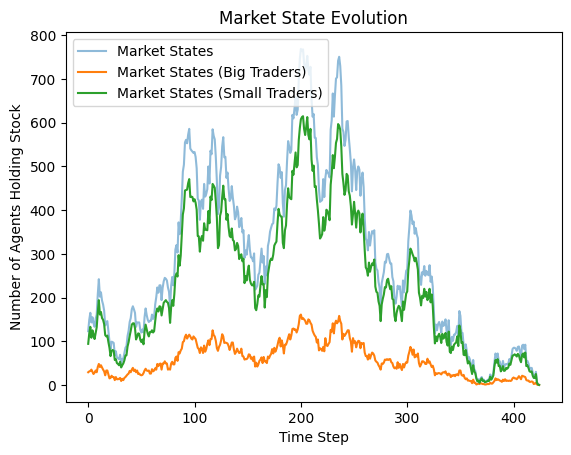

In [126]:
CA_2traders = basic_CA_financial_market(10000, 10000, 0.01, True)
CA_2traders.run_two_type_traders_model(0.2, 0.6)
CA_2traders.plot_results(two_traders= True)

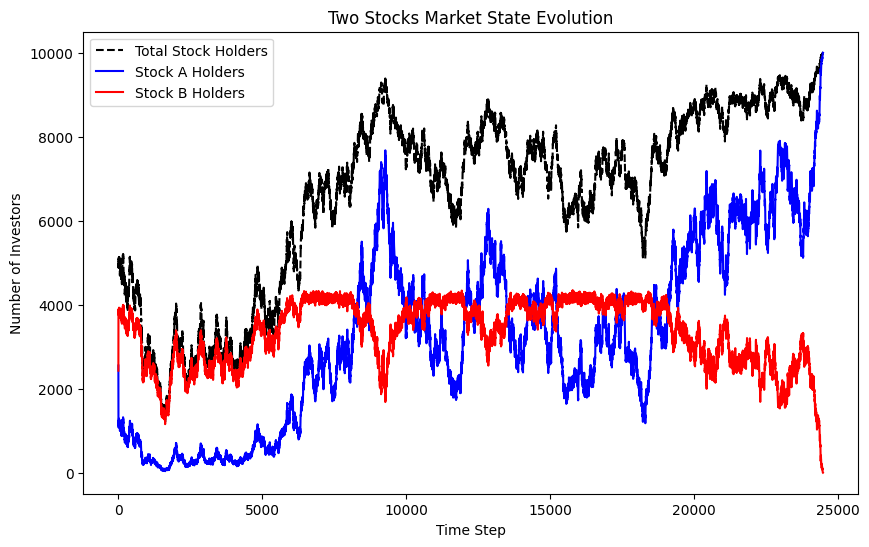

In [286]:
CA_two_stocks = basic_CA_financial_market(10000, 100000, 0.5, True)
CA_two_stocks.run_two_stocks_model(init_prob_hold_A= 0.5, alpha= 1, beta = 0.3)
CA_two_stocks.plot_two_stocks_results()

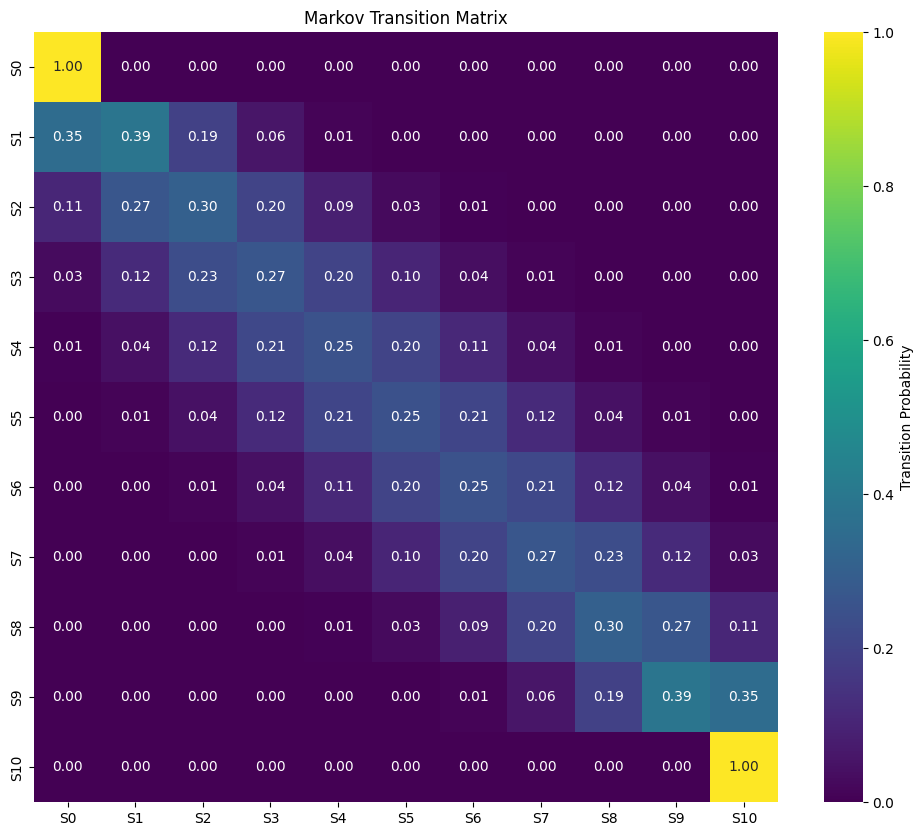

In [129]:
CA_basic_tmatrix = basic_CA_financial_market(10, 100, 0.1, True)
trans_matrix = CA_basic_tmatrix.generate_transition_matrix(True, True)